In [1]:
import requests
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def fetch_usgs_gauge_data(station_id, start_date, end_date):
    base_url = "https://api.waterdata.usgs.gov/ogcapi/v0/"  # doc here: https://api.waterdata.usgs.gov/ogcapi/v0/openapi?f=html#/daily/getDailyFeatures
    param = "00060"  # parameter code for daily discharge in CFS (see here: https://help.waterdata.usgs.gov/parameter_cd?group_cd=PHY)
    properties = "time,value,unit_of_measure"
    time = start_date + "/" + end_date

    request_str = f"collections/daily/items?f=json&lang=en-US&limit=50000&properties={properties}&skipGeometry=true&sortby=%2Btime&offset=0&datetime={time}&monitoring_location_id={station_id}&parameter_code={param}&approval_status=Approved"
    url = base_url + request_str

    with requests.Session() as session:
        print("Fetching data from USGS API...")
        print(url)
        response = session.get(url)
        response.raise_for_status()
        data = response.json()

    # count days in range to verify completeness
    expected_records = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1
    print(
        len(data["features"]),
        f"features retrieved, expected {expected_records} for full record...\n",
    )

    date_range = pd.date_range(start_date[:10], end=end_date[:10], freq="D")
    df = pd.DataFrame(date_range, columns=["date"])
    df.set_index("date", inplace=True)
    df["discharge_cfs"] = float("nan")
    for feature in data["features"]:
        date_str = feature["properties"]["time"][:10]
        value = feature["properties"]["value"]
        df.loc[date_str, "discharge_cfs"] = float(value)
    df["DOY"] = df.index.dayofyear

    # count non-nan values per year and print summary
    # only print years with < 365 values
    df["year"] = df.index.year
    summary = df.groupby("year")["discharge_cfs"].count()
    for year, count in summary.items():
        if count < 365:
            print(f"Year {year} has only {count} days with data.")

    df_doy = df.groupby("DOY").mean()

    return df, df_doy

In [3]:
def plot_daily_climatology_hydrograph(df_doy, station_id, station_name="N/A"):
    # shift data to Oct 1 - Sep 30 water year
    oct_to_dec = df_doy.index >= 274  # DOY 274 = Oct 1
    jan_to_sep = df_doy.index < 274

    # Shift DOY for plotting (Oct 1 = day 1)
    doy_shifted_oct_dec = df_doy.index[oct_to_dec] - 273  # Oct 1 -> 1
    doy_shifted_jan_sep = (
        df_doy.index[jan_to_sep] + 92
    )  # Jan 1 -> day 92-ish (depends on leap year)

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(doy_shifted_oct_dec, df_doy["discharge_cfs"][oct_to_dec], color="blue")
    ax.plot(doy_shifted_jan_sep, df_doy["discharge_cfs"][jan_to_sep], color="blue")

    # Define approximate midpoints for each month in water year
    month_starts = {
        "Oct": 1,
        "Nov": 32,
        "Dec": 62,
        "Jan": 93,
        "Feb": 124,
        "Mar": 152,
        "Apr": 183,
        "May": 213,
        "Jun": 244,
        "Jul": 274,
        "Aug": 305,
        "Sep": 335,
    }

    plt.xticks(list(month_starts.values()), list(month_starts.keys()))
    plt.xlabel("Month (Water Year: Oct-Sep)")

    plt.title(
        f"Climatological Daily Mean Discharge (1976-2005)\nStation {station_id} : {station_name}"
    )
    plt.ylabel("Discharge (cfs)")

Fetching data from USGS API...
https://api.waterdata.usgs.gov/ogcapi/v0/collections/daily/items?f=json&lang=en-US&limit=50000&properties=time,value,unit_of_measure&skipGeometry=true&sortby=%2Btime&offset=0&datetime=1976-10-01T00:00:00Z/2005-09-30T12:31:12Z&monitoring_location_id=USGS-07032000&parameter_code=00060&approval_status=Approved


6573 features retrieved, expected 10592 for full record...

Year 1976 has only 92 days with data.
Year 1994 has only 272 days with data.
Year 1995 has only 0 days with data.
Year 1996 has only 0 days with data.
Year 1997 has only 0 days with data.
Year 1998 has only 0 days with data.
Year 1999 has only 0 days with data.
Year 2000 has only 0 days with data.
Year 2001 has only 0 days with data.
Year 2002 has only 0 days with data.
Year 2003 has only 0 days with data.
Year 2004 has only 0 days with data.
Year 2005 has only 0 days with data.


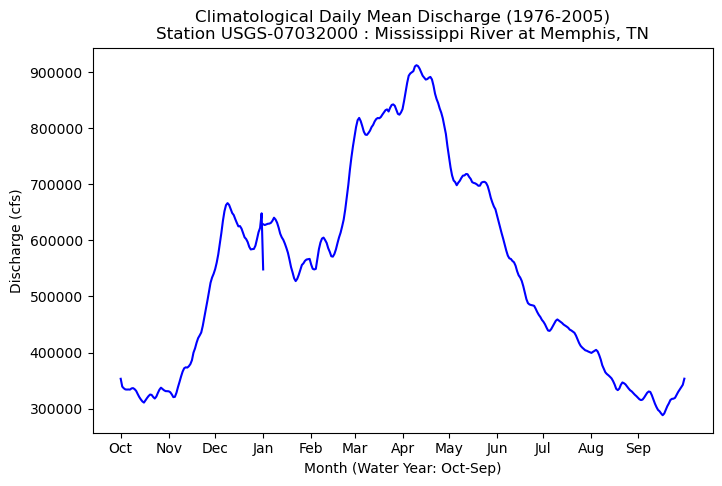

In [4]:
station_id = "USGS-07032000"  # get from POI layer in geospatial fabric geodatabase
station_name = "Mississippi River at Memphis, TN"
start_date = "1976-10-01T00:00:00Z"
end_date = "2005-09-30T12:31:12Z"

df, df_doy = fetch_usgs_gauge_data(station_id, start_date, end_date)
plot_daily_climatology_hydrograph(df_doy, station_id, station_name)

Fetching data from USGS API...
https://api.waterdata.usgs.gov/ogcapi/v0/collections/daily/items?f=json&lang=en-US&limit=50000&properties=time,value,unit_of_measure&skipGeometry=true&sortby=%2Btime&offset=0&datetime=1976-10-01T00:00:00Z/2005-09-30T12:31:12Z&monitoring_location_id=USGS-01017000&parameter_code=00060&approval_status=Approved


10592 features retrieved, expected 10592 for full record...

Year 1976 has only 92 days with data.
Year 2005 has only 273 days with data.


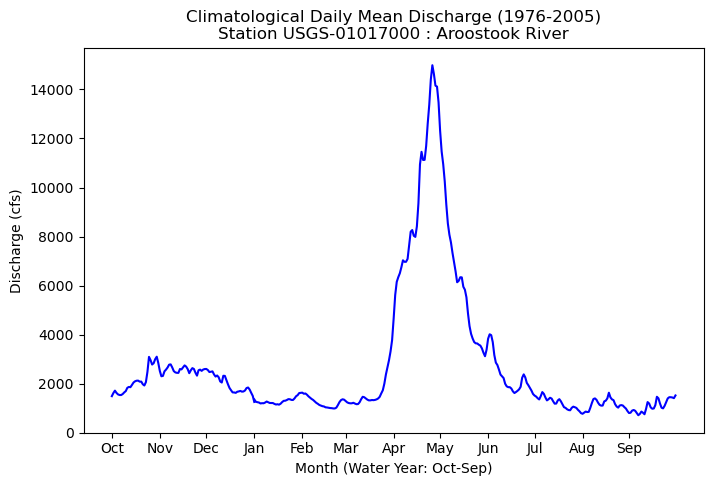

In [11]:
station_id = "USGS-01017000"  # get from POI layer in geospatial fabric geodatabase
station_name = "Aroostook River"
start_date = "1976-10-01T00:00:00Z"
end_date = "2005-09-30T12:31:12Z"

df, df_doy = fetch_usgs_gauge_data(station_id, start_date, end_date)
plot_daily_climatology_hydrograph(df_doy, station_id, station_name)